In [256]:
%load_ext autoreload
%autoreload 2
import sys
if ".." not in sys.path:
    sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt
import iisignature

from signatures.tensor_algebra import TensorAlgebra
from signatures.tensor_sequence import TensorSequence
from models.sig_vol import SigVol
from products.vanilla_option import VanillaOption
from models.model_params import LewisParams
from utility.utility import from_delta_call_to_strike

plt.rcParams["figure.figsize"]        = ((1 + np.sqrt(5)) / 2 * 5, 5)
plt.rcParams["figure.autolayout"]     = True
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams["axes.grid"]             = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Playing with signatures

In [257]:
%%time

ta = TensorAlgebra(dim=2)

Compiling...
Compilation finished.
CPU times: user 1.7 ms, sys: 18 µs, total: 1.72 ms
Wall time: 1.63 ms


In [258]:
# define basic words

N = 12
Ø = ta.from_dict({"": 1}, trunc=N)
_1 = ta.from_dict({"1": 1}, trunc=N)
_2 = ta.from_dict({"2": 1}, trunc=N)
_11 = ta.from_dict({"11": 1}, trunc=N)
_12 = ta.from_dict({"12": 1}, trunc=N)
_21 = ta.from_dict({"21": 1}, trunc=N)
_22 = ta.from_dict({"22": 1}, trunc=N)
_222 = ta.from_word("222", trunc=N)
_221 = ta.from_word("221", trunc=N)
_121 = ta.from_word("121", trunc=N)
_211 = ta.from_word("211", trunc=N)
_2222 = ta.from_word("2222", trunc=N)
_22222 = ta.from_word("22222", trunc=N)

In [259]:
ts1 = ta.from_dict(word_dict={"": 1, "2": 2, "22": 0.5, "12": 3, "112": 4, "2212": 5}, trunc=4)
ts2 = ta.from_dict(word_dict={"": 2, "22": 1.5, "11": 3}, trunc=4)

print("l1 = ", end="")
ta.print(ts1)

print("l2 = ", end="")
ta.print(ts2)

l1 = 1.0*∅ + 2.0*2 + 3.0*12 + 0.5*22 + 4.0*112 + 5.0*2212
l2 = 2.0*∅ + 3.0*11 + 1.5*22


In [260]:
print("2*l1 + l2 = ", end="")
ta.print(2 * ts1 + ts2)


print("l1 @ l2 = ", (ts1 @ ts2).squeeze().real)

print("l1|2 = ", end="")
ta.print(ts1.proj("2"))

print("l2 ⊗ 12 = ", end="")
ta.print(ts1.tensor_prod_word("12"))

2*l1 + l2 = 4.0*∅ + 4.0*2 + 3.0*11 + 6.0*12 + 2.5*22 + 8.0*112 + 10.0*2212
l1 @ l2 =  2.75
l1|2 = 2.0*∅ + 3.0*1 + 0.5*2 + 4.0*11 + 5.0*221
l2 ⊗ 12 = 1.0*12 + 2.0*212 + 3.0*1212 + 0.5*2212


In [261]:
ts3 = ta.from_dict({"1": 2, "12": 3}, trunc=6)
ts4 = ta.from_dict({"": 2, "2": 1, "22": 3}, trunc=6)
print("l3 = ", end="")
ta.print(ts3)

print("l4 = ", end="")
ta.print(ts4)

print("l3 ⊗ l4 = ", end="")
ta.print(
    ts3.tensor_prod(ts4)
)

l3 = 2.0*1 + 3.0*12
l4 = 2.0*∅ + 1.0*2 + 3.0*22
l3 ⊗ l4 = 4.0*1 + 8.0*12 + 9.0*122 + 9.0*1222


In [262]:
print("12 ⧢ 12 = ", end="")
ta.print(
    _12.shuffle_prod(_12)
)

12 ⧢ 12 = 4.0*1122 + 2.0*1212


In [263]:
print("(1 + 0.5*22)^⊗2 = ", end="")

ta.print(
    (_1 + 0.5 * _22).tensor_pow(2)
)

(1 + 0.5*22)^⊗2 = 1.0*11 + 0.5*122 + 0.5*221 + 0.25*2222


### Compute path signature

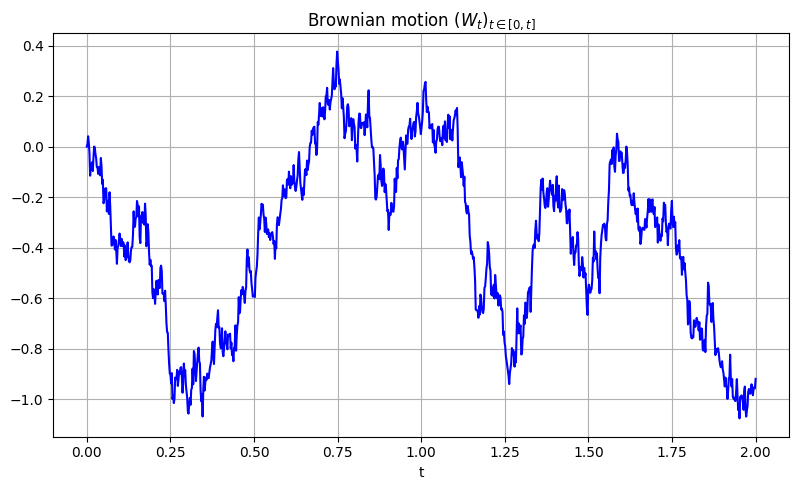

In [264]:
T = 2
t_grid = np.linspace(0, T, 1000)
rng = np.random.default_rng(seed=43)
W = np.concatenate([[0], np.cumsum(rng.normal(size=len(t_grid) - 1) * np.sqrt(np.diff(t_grid)))])

fig, ax = plt.subplots()
ax.plot(t_grid, W, "b")
ax.set_xlabel("t")
ax.set_title("Brownian motion $(W_t)_{t \in [0, t]}$")
plt.show()

In [265]:
N = 12
path = np.vstack([t_grid, W]).T
W_sig = ta.path_to_sequence(path=path, trunc=10)

### Some sanity checks

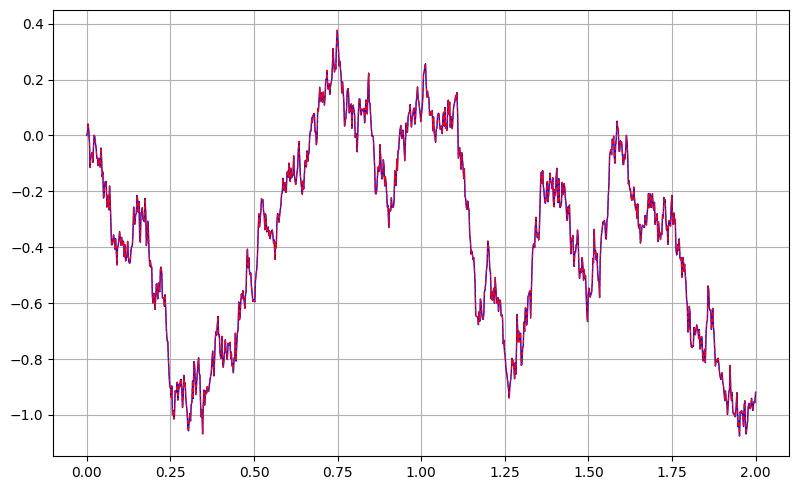

In [266]:
fig, ax = plt.subplots()

ax.plot(t_grid, np.real(W_sig @ _2), "b", lw=1)
ax.plot(t_grid, W, 'r--', lw=0.8)

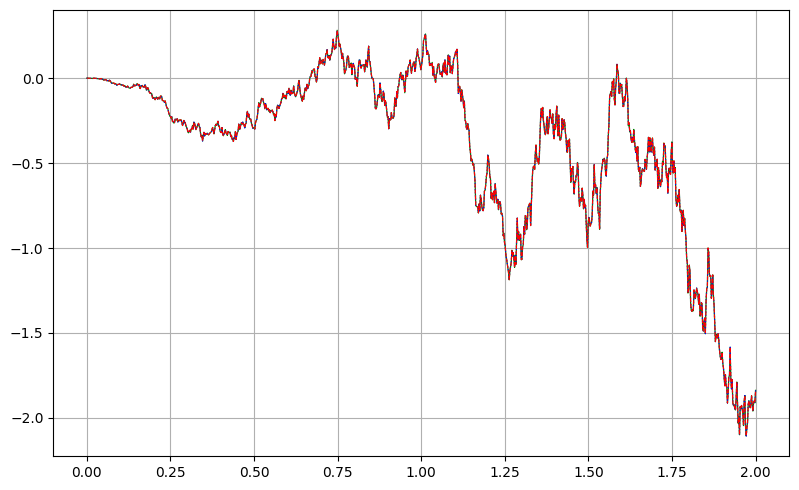

In [267]:
fig, ax = plt.subplots()

ax.plot(t_grid, np.real(W_sig @ ta.shuffle_prod(_2, _1)), "g", lw=0.9)
ax.plot(t_grid, np.real(W_sig @ (_12 + _21)), "b:", lw=0.85)
ax.plot(t_grid, W * t_grid, 'r--', lw=0.8)

### Representation time!
Let's represent an OU 
$$
dX_t = \lambda(\theta - X_t)dt + dW_t
$$
with $\lambda = 2, \theta = 2, x = 1$.

In [268]:
x = 1
theta = 2
lam = 2

l_OU = (Ø * x + _1 * lam * theta + _2).tensor_prod((-lam * _1).shuffle_exp(12))
ta.print(l_OU)

1.0*∅ + 2.0*1 + 1.0*2 + -4.0*11 + -2.0*21 + 8.0*111 + 4.0*211 + -16.0*1111 + -8.0*2111 + 32.0*11111 + 16.0*21111 + -64.0*111111 + -32.0*211111 + 128.0*1111111 + 64.0*2111111 + -256.0*11111111 + -128.0*21111111 + 512.0*111111111 + 256.0*211111111 + -1024.0*1111111111 + -512.0*2111111111 + 2047.9999999999995*11111111111 + 1023.9999999999999*21111111111 + -8192.0*111111111111 + -2048.0*211111111111


In [269]:
OU_euler = np.zeros_like(t_grid)
OU_euler[0] = x

dt = np.diff(t_grid)
dW = np.diff(W)

for i in range(OU_euler.size - 1):
    OU_euler[i + 1] = np.exp(-lam * dt[i]) * OU_euler[i] + (1 - np.exp(-lam * dt[i])) * theta + np.exp(-lam * dt[i]) * dW[i]

[]

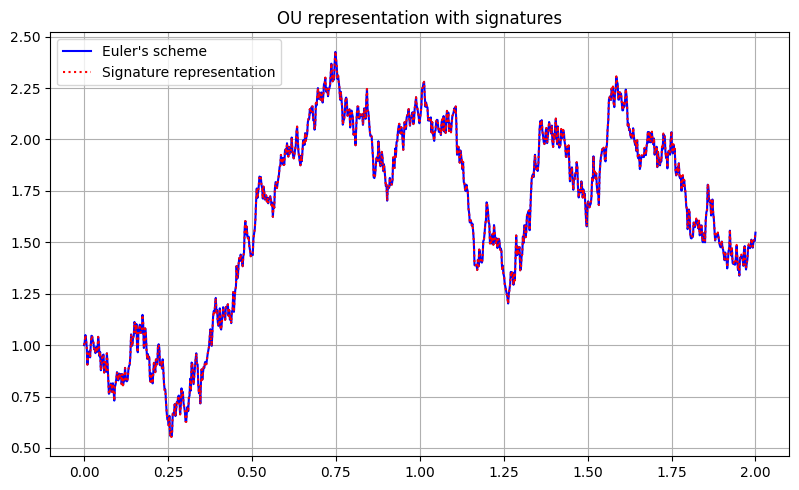

In [270]:
fig, ax = plt.subplots()

ax.plot(t_grid, OU_euler, "b", label="Euler's scheme")
ax.plot(t_grid, np.real(W_sig @ l_OU), "r:", label="Signature representation")

ax.legend()
ax.set_title('OU representation with signatures')
plt.plot()

## 2. SigVol model

In [271]:
# define basic words

N = 5
Ø = ta.from_dict({"": 1}, trunc=N)
_1 = ta.from_dict({"1": 1}, trunc=N)
_2 = ta.from_dict({"2": 1}, trunc=N)
_11 = ta.from_dict({"11": 1}, trunc=N)
_12 = ta.from_dict({"12": 1}, trunc=N)
_21 = ta.from_dict({"21": 1}, trunc=N)
_22 = ta.from_dict({"22": 1}, trunc=N)
_222 = ta.from_word("222", trunc=N)
_221 = ta.from_word("221", trunc=N)
_121 = ta.from_word("121", trunc=N)
_211 = ta.from_word("211", trunc=N)
_2222 = ta.from_word("2222", trunc=N)
_22222 = ta.from_word("22222", trunc=N)

In [272]:
rho = -0.8

vol_ts = 0.2 * Ø + 0.01 * _1 + 0.2 * _2 + 0.05 * _11 + 0.05 * _12 + 0.07 * _22 + 0.01 * _222 + \
    0.03 * _221 + 0.01 * _121 + 0.01 * _211 + 0.3 * _22222
model = SigVol(vol_ts=vol_ts, ta=ta, rho=rho)

In [273]:
ta.print(model.vol_ts)

0.2*∅ + 0.01*1 + 0.2*2 + 0.05*11 + 0.05*12 + 0.07*22 + 0.01*121 + 0.01*211 + 0.03*221 + 0.01*222 + 0.3*22222


Text(0.5, 1.0, 'Vol trajectories')

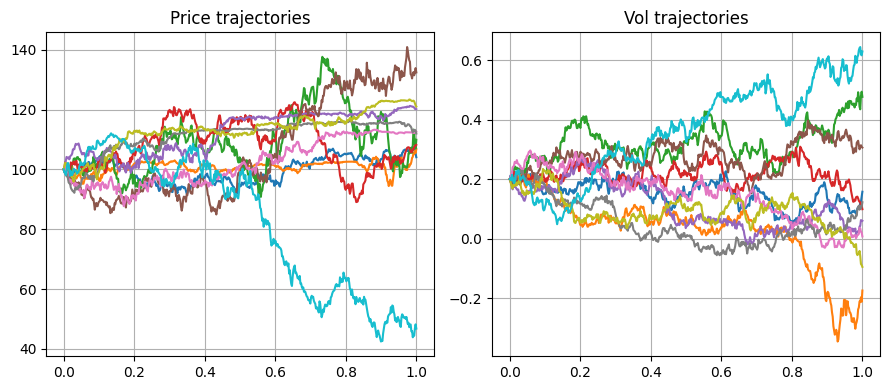

In [274]:
T = 1
F0 = 100

size = 10
N_grid = 500

t_grid = np.linspace(0, T, N_grid)
rng = np.random.default_rng(seed=42)
prices, vols = model.get_price_trajectory(t_grid=t_grid, size=size, F0=F0, rng=rng, return_vol=True)
prices

fig, ax = plt.subplots(1, 2, figsize=(9, 4))
for price, vol in zip(prices, vols):
    ax[0].plot(t_grid, price)
    ax[1].plot(t_grid, vol)
ax[0].set_title("Price trajectories")
ax[1].set_title("Vol trajectories")

### Pricing time

In [275]:
K = from_delta_call_to_strike(deltas = 1 - np.linspace(0.1, 0.9, 50), F0=F0, sigma=0.22, ttm=T)
k = np.log(K / F0)

option = VanillaOption(T=T, K=K, flag="call")

In [276]:
%%time
smile_cf = option.get_price(model=model, method="lewis", F0=F0, is_vol_surface=True, 
                            pricing_params=LewisParams(cf_timestep=0.01, N_points=25))

CPU times: user 24 s, sys: 15.6 ms, total: 24 s
Wall time: 3.51 s


[]

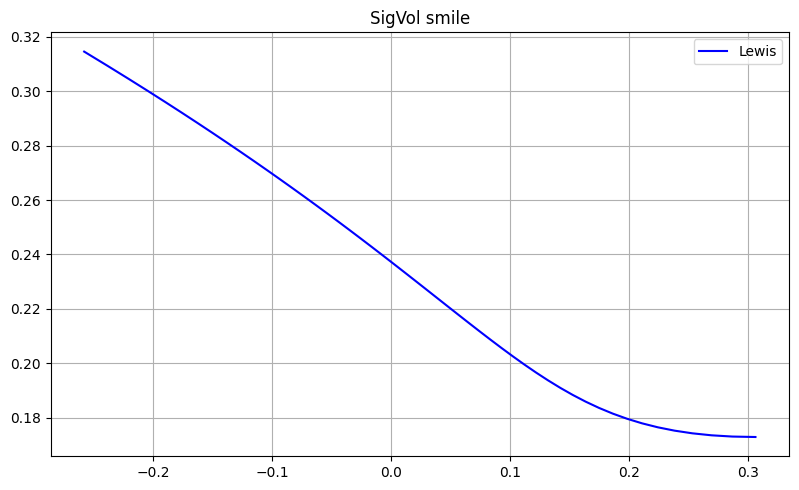

In [277]:
fig, ax = plt.subplots()

ax.plot(k, smile_cf, "b", label="Lewis")
ax.set_title("SigVol smile")
ax.legend()
plt.plot()

### Example of a volatility surface

CPU times: user 1min 4s, sys: 82.7 ms, total: 1min 4s
Wall time: 9.54 s


Text(0.5, 1.0, 'IV smiles in SigVol')

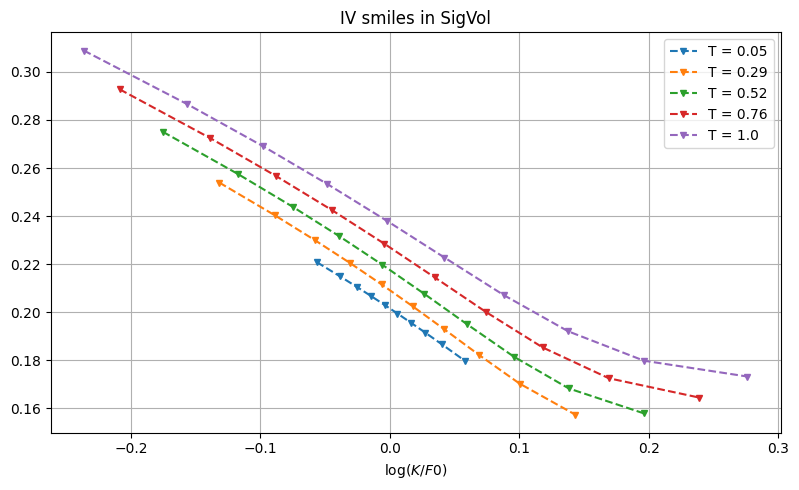

In [278]:
%%time


T_grid = np.linspace(0.05, 1, 5)
K_arr = np.array([from_delta_call_to_strike(deltas = 1 - np.linspace(0.1, 0.9, 10), F0=F0, sigma=0.2, ttm=T) for T in T_grid])
option_call_surf = VanillaOption(T=T_grid, K=K_arr, flag="call")


prices_surf = option_call_surf.get_price(model=model, method="lewis", F0=F0, is_vol_surface=False, 
                                         pricing_params=LewisParams(cf_timestep=0.01, N_points=25))

fig, ax = plt.subplots()
option_call_surf.plot_smiles(option_prices_model=prices_surf, F0=100, ax=ax)
ax.set_title("IV smiles in SigVol")